With this style transfer project, I followed a tutorial to complete this task, so much of the code is a repeat of what is in the tutorial. Despite using the code from the tutorial, this still used a considerable amount of effort and work in understanding the process and how the algorithm worked. 

Here is a youtube video that goes over the tutorial: https://www.youtube.com/watch?v=YoBEGQD3LCc&t=812s

Here is the original academic paper on the topic: https://arxiv.org/pdf/1508.06576.pdf

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import PIL.Image
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [2]:
tf.__version__

'1.13.1'

In [4]:
import vgg16
vgg16.maybe_download()

Data has apparently already been downloaded and unpacked.


In [5]:
def load_image(filename, max_size=None):
    image = PIL.Image.open(filename)
    
    if max_size is not None:
        #Calculate the appropriate rescale-factor for
        #ensuring a max height and width, while keeping
        #the proportiopn between them.
        factor = max_size / np.max(image.size)
        
        #Scale the image's height and width.
        size = np.array(image.size) * factor
        
        #The size is now floating-point because it was scaled.
        #But PIL requires the size to be integers.
        size = size.astype(int)
        
        #Resize the image.
        image = image.resize(size, PIL.Image.LANCZOS)
    #Convert to numpy floating-point array.
    return np.float32(image)

In [6]:
def save_image(image, filename):
    #Ensure the pixel-values are between 0 and 255.
    image = np.clip(image, 0.0, 255.0)
    
    #Convert to bytes.
    image = image.astype(np.uint8)
    
    #Write the image-file in jpeg-format.
    with open(filename, 'wb') as file:
        PIL.Image.fromarray(image).save(file, 'jpeg')

In [7]:
def plot_image_big(image):
    #Ensure the pixel-values are between 0 and 255.
    image = np.clip(image, 0.0, 255.0)
    
    #Convert pixels to bytes.
    image = image.astype(np.uint8)
    
    #Convert to a PIL-image and display it.
    display(PIL.Image.fromarray(image))

In [8]:
def plot_images(content_image, style_image, mixed_image):
    # Create figure with sub-plots.
    fig, axes = plt.subplots(1, 3, figsize=(10, 10))

    # Adjust vertical spacing.
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    # Use interpolation to smooth pixels?
    smooth = True
    
    # Interpolation type.
    if smooth:
        interpolation = 'sinc'
    else:
        interpolation = 'nearest'

    # Plot the content-image.
    # Note that the pixel-values are normalized to
    # the [0.0, 1.0] range by dividing with 255.
    ax = axes.flat[0]
    ax.imshow(content_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Content")

    # Plot the mixed-image.
    ax = axes.flat[1]
    ax.imshow(mixed_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Mixed")

    # Plot the style-image
    ax = axes.flat[2]
    ax.imshow(style_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Style")

    # Remove ticks from all the plots.
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [40]:
def mean_squared_error(a,b):
    return tf.reduce_mean(tf.square(a-b))

#content loss
def create_content_loss(session, model, content_image, layer_ids):
    feed_dict = model.create_feed_dict(image=content_image)
    
    layers = model.get_layer_tensors(layer_ids)
    
    values = session.run(layers, feed_dict=feed_dict)
    
    with model.graph.as_default():
        layer_losses = []
        
        for value, layer in zip(values, layers):
            value_const = tf.constant(value)
            
            loss = mean_squared_error(layer, value_const)
            
            layer_losses.append(loss)
        
        total_loss = tf.reduce_mean(layer_losses)
        return total_loss
    
#Style Loss
def gram_matrix(tensor):
    
    shape = tensor.get_shape()
    
    num_channel = int(shape[3])
    
    matrix = tf.reshape(tensor, shape=[-1, num_channel])
    
    gram = tf.matmul(tf.transpose(matrix), matrix)
    
    return gram

def create_style_loss(session, model, style_image, layer_ids):
    feed_dict = model.create_feed_dict(image=style_image)
    
    layers = model.get_layer_tensors(layer_ids)
    
    with model.graph.as_default():
        
        gram_layers = [gram_matrix(layer) for layer in layers]
        
        values = session.run(gram_layers,feed_dict = feed_dict)
        
        layer_losses = []
        
        for value, gram_layer in zip(values, gram_layers):
            value_const = tf.constant(value)
            loss = mean_squared_error(gram_layer, value_const)
            layer_losses.append(loss)
            
        total_loss = tf.reduce_mean(layer_losses)
        
        return total_loss

#Denoise Loss/total-variation loss
def create_denoise_loss(model):
    loss = tf.reduce_mean(tf.abs(model.input[:,1:,:,:] - model.input[:,:-1,:,:])) + tf.reduce_mean(tf.abs(model.input[:,:,1:,:] - model.input[:,:,:-1,:]))
    return loss

def style_transfer(content_image, style_image, content_layer_ids, style_layer_ids, weight_content, weight_style=10.0,
                  weight_denoise=0.3, num_iterations=120, step_size=10.0):

    model = vgg16.VGG16()
    
    session = tf.InteractiveSession(graph=model.graph, config=config)
    
    # Print the names of the content-layers.
    print("Content layers:")
    print(model.get_layer_names(content_layer_ids))
    print()
    
    # Print the namesof the style-layers.
    print("Styler layers:")
    print(model.get_layer_names(style_layer_ids))
    print()
    
    loss_content = create_content_loss(session=session,
                                       model=model,
                                       content_image=content_image,
                                       layer_ids=content_layer_ids)
    loss_style = create_style_loss(session=session,
                                    model=model,
                                    style_image=style_image,
                                    layer_ids=style_layer_ids)
    loss_denoise = content = create_denoise_loss(model)
    
    adj_content = tf.Variable(1e-10, name='adj_content')
    adj_style = tf.Variable(1e-10, name='adj_style')
    adj_denoise = tf.Variable(1e-10, name='adj_denoise')
    
    session.run([adj_content.initializer,
                adj_style.initializer,
                adj_denoise.initializer])
    
    #
    update_adj_content = adj_content.assign(1.0 / (loss_content + 1e-10))
    update_adj_style = adj_content.assign(1.0 / (loss_style + 1e-10))
    update_adj_denoise = adj_content.assign(1.0 / (loss_denoise + 1e-10))
    
    
    # This is the weighted loss-function that we will minimize
    # below in order to generate the mixed-image.
    # Because we multiply the loss-values with their reciprocal
    # adjustment values, we can use relative weights for the
    # loss-functions that are easier to select, as they are
    # independent of the exact choice of style- and content-layers.
    loss_combined = weight_content * update_adj_content * loss_content + \
                    weight_style * update_adj_style * loss_style + \
                    weight_denoise * update_adj_denoise * loss_denoise
    
    gradient = tf.gradients(loss_combined, model.input)
    
    run_list = [gradient, update_adj_content, update_adj_style, update_adj_denoise]
    mixed_image = np.random.rand(*content_image.shape) + 128
    
    for i in range(num_iterations):
        feed_dict = model.create_feed_dict(image=mixed_image)
        
        #Use Tensorflow to calculate the value of the 
        #graduen as well as updating the adjustment values.
        grad, adj_content_val, adj_style_val, adj_denoise_val = session.run(run_list, feed_dict=feed_dict)
        
        #Reduce the dimensionality of the gradient.
        #Remove single-dimensional entries from the shape of an arrary
        grad = np.squeeze(grad)
        
        #Scale the step-size according to the gradient-values.
        #Ratio of weights:updates
        #akin to learning rate
        step_size_scaled = step_size / (np.std(grad) + 1e-8)
        
        #Update the image by following the gradient.
        #gradient descent
        mixed_image -= grad * step_size_scaled
        
        #Ensure the image has valid pixel=values between 0 and 255.
        #Given an interval, values outside the interval are clipped
        #to the interval edges.
        mixed_image = np.clip(mixed_image, 0.0, 255.0)
        
        #Print a little progress-indicator.
        
        if (i % 10 == 0) or (i == num_iterations - 1):
            print()
            print("Iteration:", i)
            
            #Print adjustment weights for loss-functions.
            msg = "Weight Adj. for Content: {0:.2e}, Style: {1:.2e}, Denoise: {2: .2e}"
            print(msg.format(adj_content_val, adj_style_val, adj_denoise_val))
            
            #in larger resolution
            #Plot the content-, style-, and mixed-images.
            plot_images(content_image=content_image,
                       style_image=style_image,
                       mixed_image=mixed_image)
            
    print()
    print("Final image:")
    plot_image_big(mixed_image)

    #Close the Tensorflow session to release its resources.
    session.close()
        
    #Return the mixed-image.
    return mixed_image

In [124]:
content_filename = 'jordan1.jpg'
content_image = load_image(content_filename, max_size=300)

style_filename = 'the-scream.jpg'
style_image = load_image(style_filename, max_size=300)


content_layer_ids = [4]
# The VGG16-model has 13 convolutional layers.
# This selects all those layers as the style-layers.
# This is somewhat slow to optimize.
style_layer_ids = list(range(13))

# You can also select a sub-set of the layers, e.g. like this:
# style_layer_ids = [1, 2, 3, 4]



c:\users\kaweie\appdata\local\continuum\anaconda3\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Content layers:
['conv3_1/conv3_1']

Styler layers:
['conv1_1/conv1_1', 'conv1_2/conv1_2', 'conv2_1/conv2_1', 'conv2_2/conv2_2', 'conv3_1/conv3_1', 'conv3_2/conv3_2', 'conv3_3/conv3_3', 'conv4_1/conv4_1', 'conv4_2/conv4_2', 'conv4_3/conv4_3', 'conv5_1/conv5_1', 'conv5_2/conv5_2', 'conv5_3/conv5_3']


Iteration: 0
Weight Adj. for Content: 1.71e-28, Style: 1.71e-28, Denoise:  1.71e-28


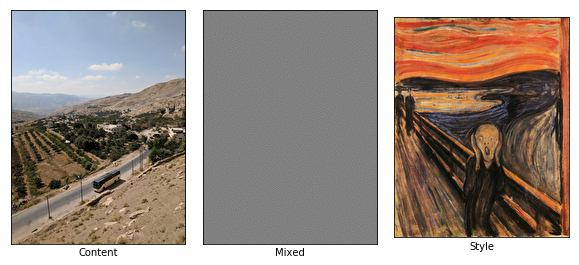


Iteration: 10
Weight Adj. for Content: 2.33e-27, Style: 2.33e-27, Denoise:  2.33e-27


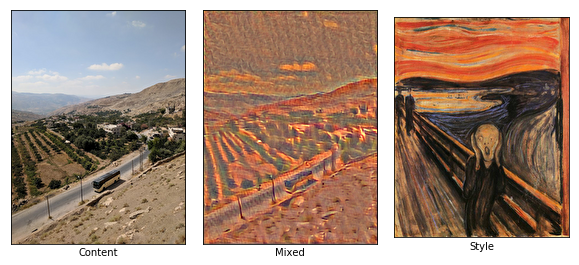


Iteration: 20
Weight Adj. for Content: 3.05e-27, Style: 3.05e-27, Denoise:  3.05e-27


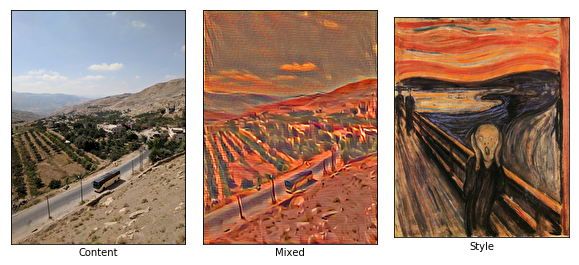


Iteration: 30
Weight Adj. for Content: 8.08e-27, Style: 8.08e-27, Denoise:  8.08e-27


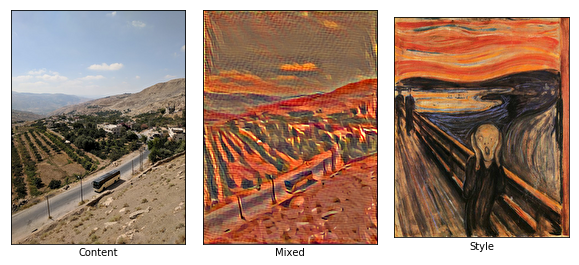


Iteration: 40
Weight Adj. for Content: 1.09e-26, Style: 1.09e-26, Denoise:  1.09e-26


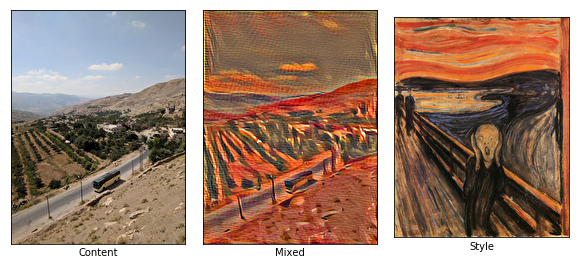


Iteration: 50
Weight Adj. for Content: 1.38e-26, Style: 1.38e-26, Denoise:  1.38e-26


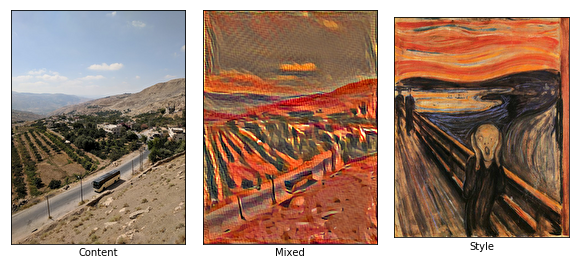


Iteration: 60
Weight Adj. for Content: 2.35e-26, Style: 2.35e-26, Denoise:  2.35e-26


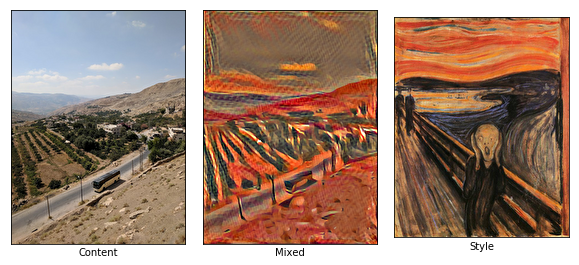


Iteration: 70
Weight Adj. for Content: 1.49e-26, Style: 1.49e-26, Denoise:  1.49e-26


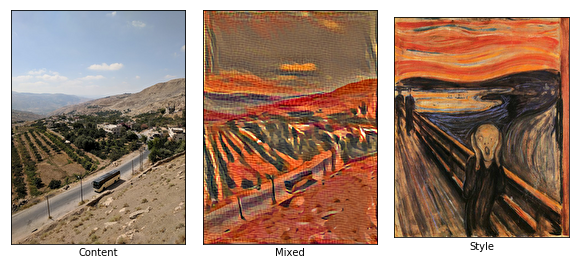


Iteration: 80
Weight Adj. for Content: 1.70e-26, Style: 1.70e-26, Denoise:  1.70e-26


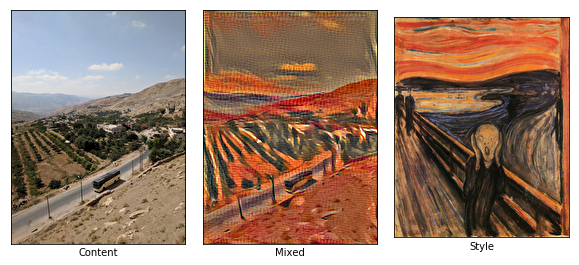


Iteration: 90
Weight Adj. for Content: 4.09e-27, Style: 4.09e-27, Denoise:  4.09e-27


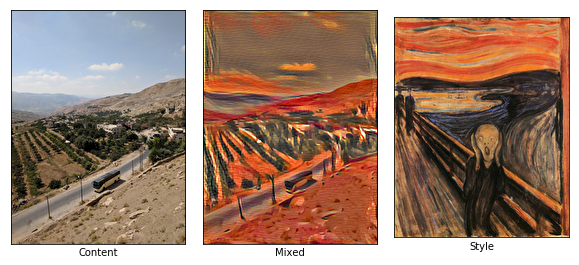


Iteration: 100
Weight Adj. for Content: 1.27e-26, Style: 1.27e-26, Denoise:  1.27e-26


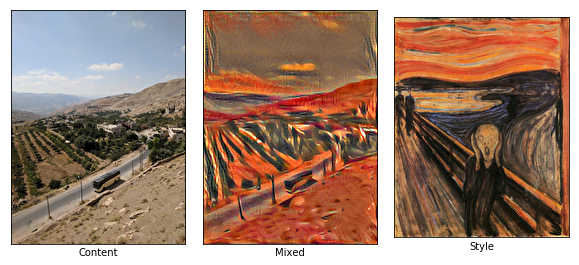


Iteration: 110
Weight Adj. for Content: 1.49e-26, Style: 1.49e-26, Denoise:  1.49e-26


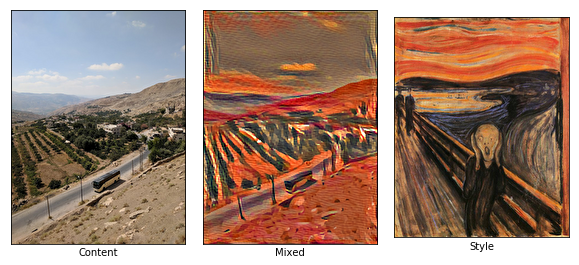


Iteration: 119
Weight Adj. for Content: 1.35e-27, Style: 1.35e-27, Denoise:  1.35e-27


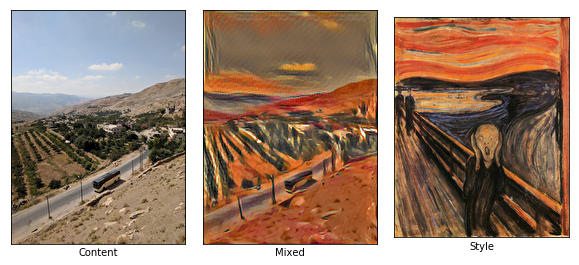


Final image:


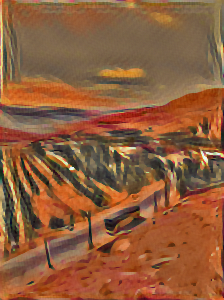

Wall time: 2min 46s


In [125]:
%%time
img = style_transfer(content_image=content_image,
                     style_image=style_image,
                     content_layer_ids=content_layer_ids,
                     style_layer_ids=style_layer_ids,
                     weight_content=4.5,
                     weight_style=10.0,
                     weight_denoise=4.5,
                     num_iterations=120,
                     step_size=10.0)

# Other Results

A photo of the Eiffel tower with the painting "Starry night" onto the photo.

Populating the interactive namespace from numpy and matplotlib


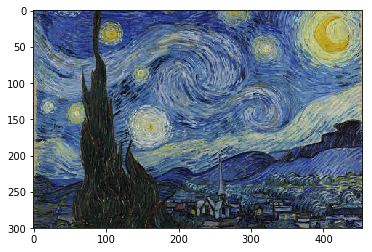

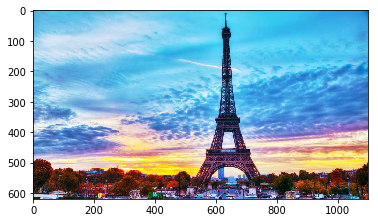

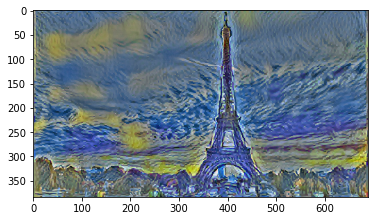

In [135]:
%pylab inline
import matplotlib.image as mpimg
img=mpimg.imread('starry_night.jpg')
imgplot = plt.imshow(img)
plt.show()

img=mpimg.imread('eiffel.jpg')
imgplot = plt.imshow(img)
plt.show()

img=mpimg.imread('eiffel_starry.png')
imgplot = plt.imshow(img)
plt.show()

Next I transposed the style of Edvard Muncher's scream onto a photo of the Jordanian lanscape

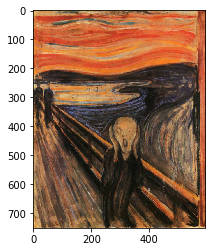

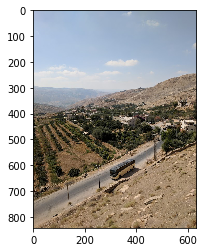

In [137]:
img=mpimg.imread('the-scream.jpg')
imgplot = plt.imshow(img)
plt.show()

img=mpimg.imread('jordan1.jpg')
imgplot = plt.imshow(img)
plt.show()

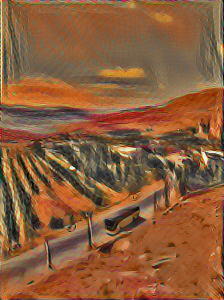

In [108]:
plot_image_big(img)

These are some other photos that I applied a transfer from a famous painting. I decided not to explicitly include those here, but if you would like to know more I could answer that question.

I used the scream again, but then I applied a Francisco Goya painting and another painting by Theodore Thericault titled "Madwoman".

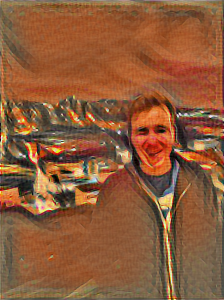

In [105]:
plot_image_big(img)

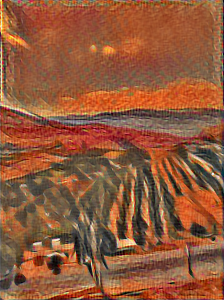

In [111]:
plot_image_big(img)

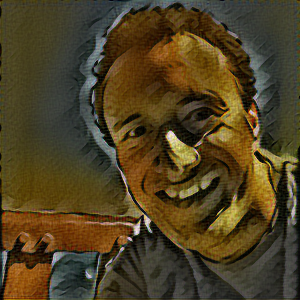

In [114]:
plot_image_big(img)

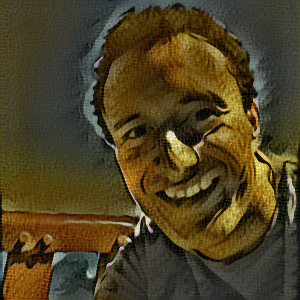

In [120]:
plot_image_big(img)

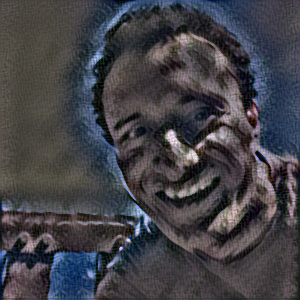

In [123]:
plot_image_big(img)
